# Tequila Tutorial: 
## Handling Optimizers, Initializing parametrized circuits

In [1]:
# Import everything we need here
import tequila as tq
numpy = tq.numpy

In the following example we will optimize a simple two qubit VQE with an Ansatz that is parametrized by two parameters.
The Hamiltonian is also very simple and defined in the box below.
$$ H = \sigma_x(1) + c \sigma_z(1) - \sigma_z(0)$$

<br>
The tutorial is \textbf{not} a guideline to optimization strategies but only intends to show tequilas functionality

In [2]:
c = 0.5
H = tq.paulis.X(1) + c*tq.paulis.Z(1) - tq.paulis.Z(0)

Lets take a look at the spectrum of this very simple Hamiltonian  
Keep in mind: Tequila is not a numerical linear algebra package, so better not try to diagonalize Hamiltonians  
we however added this feature for user convenience in examples  
In the future we might have interfaces to more powerfull numerical packages ... feel free to contribute :-) 

In [3]:
matrix = H.to_matrix()
e, v = numpy.linalg.eigh(matrix)
e

DeviceArray([-2.118034  , -0.11803401,  0.11803401,  2.118034  ], dtype=float32)

And here we initialize our Ansatz circuit which is parametrized by a and b.<br>

We show to ways to initialize Variables:
Variable a is initialized with a convenience string based initialization <br>
Variable b is initialized as Variable which allows you to conveniently transforming it when initializing gates. Here we do a simple rescaling as an example <br>
Note that you don't need strings to name variables but can use any hashable non-numeric type (meaning anything that is not interpreted as number). 

For example: tq.Variable(name=(0,1,2,3)) will also work


The Ansatz has no specific meaning and it is more to show different ways how to deal with variables.
See for instance that you can scale them and use the same variable in multiple gates. (See the other tutorials for more examples)

In [4]:
a = tq.Variable(name="a")
b = tq.Variable(name="b")
c = tq.Variable(name="c")

a = 2.0*a*tq.numpy.pi # optimize a in units of 2pi
b = 2.0*b*tq.numpy.pi # optimize b in units of 2pi
c = 2.0*c*tq.numpy.pi # optimize c in units of 2pi

U = tq.gates.Ry(target=0, angle=a)
U += tq.gates.Ry(target=1, control=0, angle=b)
U += tq.gates.X(target=1)
U += tq.gates.Ry(target=1, control=0, angle=-b)
U += tq.gates.Ry(target=0,angle=c)


In [5]:
print(U)

circuit: 
Ry(target=(0,), parameter=Objective with 0 unique expectation values
variables = [a]
types     = [])
Ry(target=(1,), control=(0,), parameter=Objective with 0 unique expectation values
variables = [b]
types     = [])
X(target=(1,))
Ry(target=(1,), control=(0,), parameter=Objective with 0 unique expectation values
variables = [b]
types     = [])
Ry(target=(0,), parameter=Objective with 0 unique expectation values
variables = [c]
types     = [])



In [6]:
# nice output (depends on which backends you have installed)
tq.draw(U)

0: ───Ry(0.318309886183791*pi*f((a,))_0)───@────────────────────────────────────────@────────────────────────────────────Ry(0.318309886183791*pi*f((c,))_3)───
                                           │                                        │
1: ────────────────────────────────────────Ry(0.318309886183791*pi*f((b,))_1)───X───Ry(0.318309886183791*pi*f((b,))_2)────────────────────────────────────────


In the next box we form an objective out of our Hamiltonian and our Ansatz and pass it down to the optimizer.
In the following boxes we show how the results of the optimizer can be plotted

See further below for some small exercises and additional information 

First lets see how objectives are created and simulated

In [7]:
O = tq.Objective.ExpectationValue(U=U, H=H)
variables = {"a":0.25, "b":0.25, "c":0.25}
energy = tq.simulate(O, variables=variables)
wfn = tq.simulate(U, variables=variables)
evaluate_squared = tq.simulate(O**2, variables=variables)
print("energy : {}".format(energy))
print("wfn    : {}".format(wfn))
print("squared: {}".format(evaluate_squared))

energy : -6.556708946614531e-08
wfn    : -0.5000|00> +0.5000|10> +0.5000|01> +0.5000|11> 
squared: 4.2990428789557375e-15


Now the objective can be optimized 

We will also set the initial values of the variables that can be passed to the optimizer.  
Values of variables are passed as dictionaries where the keys are tequila variables and the values are floats.  

In [8]:
initial_values = {'a':0.3, 'b':0.3, 'c':0.3}
O = tq.Objective.ExpectationValue(U=U, H=H)
result = tq.optimizer_scipy.minimize(objective=O, method="bfgs", initial_values=initial_values, tol=1.e-3, method_options={"gtol":1.e-3})

Optimizer: <class 'tequila.optimizers.optimizer_scipy.OptimizerSciPy'> 
backend         : None
backend_options : {}
samples         : None
save_history    : True
noise_model     : None

Method          : BFGS
Objective       : 1 expectationvalues
gradient        : 12 expectationvalues

active variables : 3

Gradient:

Hessian:

None
E=-0.66770238  angles= {c: 0.3, b: 0.3, a: 0.3}  samples= None
E=-0.86641482  angles= {c: 0.3886562339058441, b: 1.3058406768884259, a: 0.32290425519998417}  samples= None
E=-0.35434409  angles= {c: 0.7432811695292205, b: 5.3292033844421285, a: 0.41452127599992095}  samples= None
E=-0.80480921  angles= {c: 0.47595029847112946, b: 2.296226994041704, a: 0.3454565952234802}  samples= None
E=-1.08258143  angles= {c: 0.47268466185431224, b: 2.3162437658743937, a: 0.3555276683594922}  samples= None
E=-1.92438448  angles= {c: 0.45962211538704334, b: 2.396310853205154, a: 0.3958119609035401}  samples= None
E=+0.06258418  angles= {c: 0.23628931675683343, b: 2.435466

In [9]:
# final energy
result.energy

-2.118033986209923

Plot out the History:
Note, that we choose bad initial points since they are close to the maximum

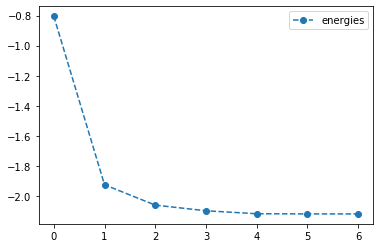

In [10]:
result.history.plot('energies')

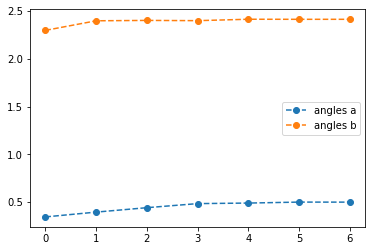

In [11]:
result.history.plot(property='angles', key=["a", "b"])

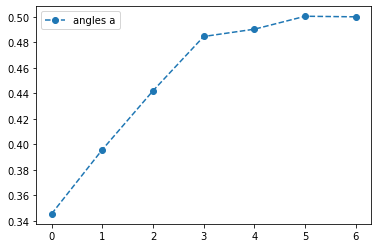

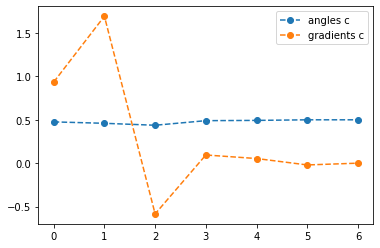

In [12]:
# Convenience in the history plot
result.history.plot(property='angles', key="a")
result.history.plot(property=['angles', 'gradients'], key=["c"])

# FAQ

## 1: How can I extract the parameters from a given circuit?

Call the 'extract_parameters' attribute and get back a list of all Variables in the circuit

In [13]:
angles = U.extract_variables()
angles

[c, b, a]

## 2: How can I do measurement based simulation?
Pass down the 'samples' keyword to simulate finite samples
See the later exercises to play around with sample number and optimization methods.

Feel free to play around with the number of samples 
Don't excpect miracles from the optimizer, you might need to hit return a few times or increase the number of samples.<br>Note that stochastic gradients are not yet supported
<br>Note also that we did not set the initial parameters, so we will start with all parameters set to 0 which is a stationary point in this example (full wavefunction simulation would get stuck, see also the exercise below).

Sampling based simulation needs improvement. Don't expect too much, but feel free to contribute

Lets only optimize veriable b and set the other to the correct value to also show how that works

Optimizer: <class 'tequila.optimizers.optimizer_scipy.OptimizerSciPy'> 
backend         : None
backend_options : {}
samples         : 100
save_history    : True
noise_model     : None

Method          : BFGS
Objective       : 1 expectationvalues
gradient        : 8 expectationvalues

active variables : 1

Gradient:

Hessian:

None
E=-0.62000000  angles= {b: 0.3, a: 0.3, c: 0.3}  samples= 100
E=-0.95000000  angles= {b: 1.31, a: 0.3, c: 0.3}  samples= 100
E=-1.32000000  angles= {b: 5.3500000000000005, a: 0.3, c: 0.3}  samples= 100
E=-1.58000000  angles= {b: 5.479708977881824, a: 0.3, c: 0.3}  samples= 100
E=-1.64000000  angles= {b: 5.432965928010243, a: 0.3, c: 0.3}  samples= 100
E=-1.86000000  angles= {b: 5.42498881831508, a: 0.3, c: 0.3}  samples= 100
E=-1.69000000  angles= {b: 5.42574854313947, a: 0.3, c: 0.3}  samples= 100
E=-1.56000000  angles= {b: 5.424988871632852, a: 0.3, c: 0.3}  samples= 100
E=-1.99000000  angles= {b: 5.42498881831508, a: 0.3, c: 0.3}  samples= 100
E=-1.7700000

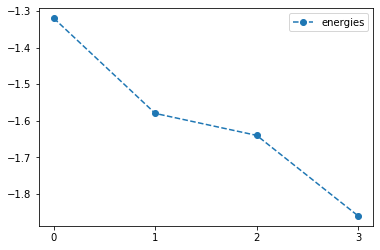

result =  -1.8599999999999999


In [14]:
O = tq.Objective.ExpectationValue(U=U, H=H)
initial_values["a"] = 0.3
initial_values["c"] = 0.3
initial_values["b"] = 0.3
result = tq.optimizer_scipy.minimize(objective=O, variables=["b"], initial_values = initial_values, tol=1.e-3, samples=100, method="bfgs")
result.history.plot('energies')
print("result = ", result.energy)

## 3: Which Simulator was used and how can I choose the simulator?

You can pass down the simulator to the optimizer by the simulator keyword (see below)
If no specific simulator was chosen by you that means the simulator is automatically picked. Which simulator is picked depends on what simulators you have installed and if you demanded a full wavefunction to be simulated or not.

You can check which simulators you have installed with the following

In [15]:
print(tq.show_available_simulators())

Supported Backends:

qulacs
qiskit
cirq
pyquil
symbolic

Installed Wavefunction Simulators:

qulacs
pyquil
qiskit
cirq
symbolic

Installed Wavefunction Samplers:

qulacs
pyquil
qiskit
cirq
None


Here is how you would initialize a simulator and pass it down the optimizer.
The if statement is just to prevent your Ipython kernel from crashing when you have not installed the simulator
Feel free to change it to something you have installed

Optimizer: <class 'tequila.optimizers.optimizer_scipy.OptimizerSciPy'> 
backend         : qiskit
backend_options : {}
samples         : None
save_history    : True
noise_model     : None

Method          : BFGS
Objective       : 1 expectationvalues
gradient        : 12 expectationvalues

active variables : 3

Gradient:

Hessian:

None
E=-0.66770238  angles= {c: 0.3, b: 0.3, a: 0.3}  samples= None
E=-0.86641482  angles= {c: 0.3886562339058441, b: 1.3058406768884259, a: 0.32290425519998417}  samples= None
E=-0.35434409  angles= {c: 0.7432811695292205, b: 5.3292033844421285, a: 0.41452127599992095}  samples= None
E=-0.80480921  angles= {c: 0.47595029847112946, b: 2.296226994041704, a: 0.3454565952234802}  samples= None
E=-1.08258143  angles= {c: 0.47268466185431224, b: 2.3162437658743937, a: 0.35552766835949223}  samples= None
E=-1.92438448  angles= {c: 0.4596221153870433, b: 2.3963108532051542, a: 0.3958119609035403}  samples= None
E=+0.06258418  angles= {c: 0.23628931675683376, b: 2.435

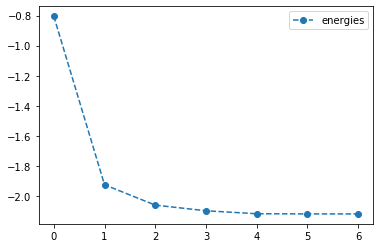

In [16]:
if 'qiskit' in tq.INSTALLED_BACKENDS: # failsafe to only execute cell when qiskit is actually there
    O = tq.Objective.ExpectationValue(U=U, H=H)
    result = tq.optimizer_scipy.minimize(objective=O,
                                       initial_values=initial_values,
                                       backend="qiskit")
    result.history.plot()

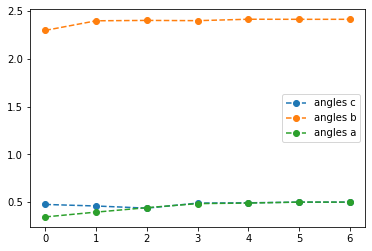

In [17]:
result.history.plot('angles')

## 4: Can I use numerical evaluation of gradients

Yes you can, by passing down `use_gradient = False` or `use_gradient = "2-point"`.  
`use_gradient = '3-point' or 'cs' ` are also possible for scipy methods which support them.  
Check out the documentation of scipy.optimize.minimize for that.  
You can also pass down further options (again, check scipy documentation) for different methods.  
An important additional option is `eps` which defines the stepsizes for the '2-point' method.

In [18]:
result = tq.optimizer_scipy.minimize(objective=O,
                                    initial_values=initial_values,
                                    use_gradient='2-point',
                                    method_options = {'eps':1.e-3})

Optimizer: <class 'tequila.optimizers.optimizer_scipy.OptimizerSciPy'> 
backend         : None
backend_options : {}
samples         : None
save_history    : True
noise_model     : None

Method          : BFGS
Objective       : 1 expectationvalues
gradient        : 12 expectationvalues

active variables : 3

Gradient:

Hessian:

None
E=-0.66770238  angles= {c: 0.3, b: 0.3, a: 0.3}  samples= None
E=-0.86641482  angles= {c: 0.3886562339058441, b: 1.3058406768884259, a: 0.32290425519998417}  samples= None
E=-0.35434409  angles= {c: 0.7432811695292205, b: 5.3292033844421285, a: 0.41452127599992095}  samples= None
E=-0.80480921  angles= {c: 0.47595029847112946, b: 2.296226994041704, a: 0.3454565952234802}  samples= None
E=-1.08258143  angles= {c: 0.47268466185431224, b: 2.3162437658743937, a: 0.3555276683594922}  samples= None
E=-1.92438448  angles= {c: 0.45962211538704334, b: 2.396310853205154, a: 0.3958119609035401}  samples= None
E=+0.06258418  angles= {c: 0.23628931675683343, b: 2.435466

## 5: Can I use Hessian based optimizations, and can I evaluate Hessians numerically?

Yes you can, by just picking those methods (like for example 'dogleg' or 'newton-cg').
For all 'trust-\*' methods you can also pick different options (see again scipy documentation)

Numerical evaluation for hessians works in the same way as for gradients by passing down `use_hessian` instead of `use_gradient`.  
Be aware that not all combinations of `use_gradient` and `use_hessian` will work (usually you need to have the gradients analytically) and that most scipy methods do not support numerical evaluation of Hessians.
Also do not confuse that with methods which use an approximation of the Hessian.
Again: Check the scipy documentation for more information

Here comes a small example where (note that the methods above will not converge to the minimum for this initial_values)

In [19]:
tq.optimizer_scipy.OptimizerSciPy.hessian_based_methods

['TRUST-KRYLOV',
 'NEWTON-CG',
 'DOGLEG',
 'TRUST-NCG',
 'TRUST-EXACT',
 'TRUST-CONSTR']

In [20]:
options = {
    "initial_tr_radius":0.05,
    "max_tr_radius":0.1
}

result = tq.optimizer_scipy.minimize(objective=O,
                                    initial_values={"a":0.25, "b":0.25, "c":0.25},
                                    method = "trust-exact",
                                    method_options = options)


Optimizer: <class 'tequila.optimizers.optimizer_scipy.OptimizerSciPy'> 
backend         : None
backend_options : {}
samples         : None
save_history    : True
noise_model     : None

Method          : TRUST-EXACT
Objective       : 1 expectationvalues
gradient        : 12 expectationvalues
hessian         : 180 expectationvalues

active variables : 3

Gradient:

Hessian:

E=-0.00000007  angles= {c: 0.25, b: 0.25, a: 0.25}  samples= None
E=+0.05129849  angles= {c: 0.5055104775766944, b: 1.0753385471563042, a: 0.7535182999916196}  samples= None
E=-1.54498606  angles= {c: 0.27731303752572806, b: 0.490225804920117, a: 0.32165051548766865}  samples= None
E=-1.92693919  angles= {c: 0.4304152219529205, b: 0.37410841961410807, a: 0.48157697969330854}  samples= None
E=-2.11480148  angles= {c: 0.488930087935853, b: 0.41474457436409573, a: 0.48518960558553104}  samples= None
E=-2.11802893  angles= {c: 0.500585920937999, b: 0.4117583404951248, a: 0.5004980688483419}  samples= None
E=-2.11803399 

# Exercises

See farther down for solutions

## Exercise 1

You can pass down initial_values to the optimizer in the same format as you can do it with the circuit (see above).
Figure out how to do that by checking out the documentation of the 'minimize' function.

## Exercise 2
Figure out which method the optimizer above used and how to use a different optimization method. To do so check out the documentation of the 'minimize' function

In [21]:
# hint
tq.optimizer_scipy.available_methods()

['NELDER-MEAD',
 'COBYLA',
 'POWELL',
 'SLSQP',
 'L-BFGS-B',
 'BFGS',
 'CG',
 'TNC',
 'TRUST-KRYLOV',
 'NEWTON-CG',
 'DOGLEG',
 'TRUST-NCG',
 'TRUST-EXACT',
 'TRUST-CONSTR']

## Exercise 3
If you initialize both parameters to 0.0 you will directly hit a stationary point which causes the optimizer stop.
Find out how you can impose bounds on the variables in order to prevent the optimizer from hitting that point.

Again: Check the documentation of the 'minimize' function.

Note: Not all optimization methods of SciPy support bounds on the variables

Note: It is not enough to just restrict the point 0.0

# Solutions

## Exercise 1 & 2

In [22]:
O = tq.Objective.ExpectationValue(U=U, H=H)
result = tq.optimizer_scipy.minimize(objective=O, method='TNC', maxiter=10, initial_values={'a':-0.2, 'b':-0.1})

Optimizer: <class 'tequila.optimizers.optimizer_scipy.OptimizerSciPy'> 
backend         : None
backend_options : {}
samples         : None
save_history    : True
noise_model     : None

Method          : TNC
Objective       : 1 expectationvalues
gradient        : 12 expectationvalues

active variables : 3

Gradient:

Hessian:

None
E=-1.53133589  angles= {c: 0.16846669834848696, b: -0.1, a: -0.2}  samples= None
E=-1.53133616  angles= {c: 0.16846671212892103, b: -0.09999993176531412, a: -0.20000000535066648}  samples= None
E=-1.62196825  angles= {c: 0.17752398023508334, b: -0.055152299173819155, a: -0.2035167611011087}  samples= None
E=-1.62196825  angles= {c: 0.17752399356161377, b: -0.0551522984864377, a: -0.203516762107104}  samples= None
E=-0.68436669  angles= {c: 1.0361305704875976, b: -0.010865434421966857, a: -0.2683313967378351}  samples= None
E=+0.01101877  angles= {c: 0.6068272753613404, b: -0.033008866797893, a: -0.23592407891947192}  samples= None
E=-1.12768557  angles= {c: 

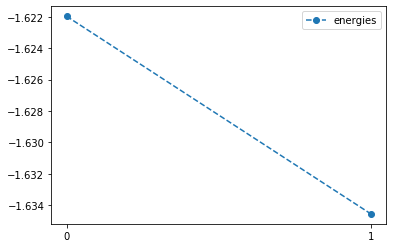

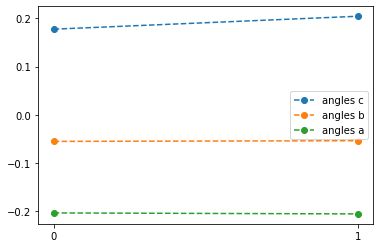

In [23]:
result.history.plot('energies')
result.history.plot('angles')

## Exercise 3

Optimizer: <class 'tequila.optimizers.optimizer_scipy.OptimizerSciPy'> 
backend         : None
backend_options : {}
samples         : None
save_history    : True
noise_model     : None

Method          : TNC
Objective       : 1 expectationvalues
gradient        : 12 expectationvalues

active variables : 3

Gradient:

Hessian:

None
E=-1.20482303  angles= {c: 0.8744867269514646, b: 0.0, a: 0.0}  samples= None
E=-1.20482434  angles= {c: 0.8744869603217648, b: 0.0, a: 6.641725036615753e-08}  samples= None
E=-1.46045676  angles= {c: 1.0071505959934723, b: 0.0, a: 0.03775617290955773}  samples= None
E=-1.46810764  angles= {c: 0.9408186614724685, b: 0.0, a: 0.018878086454778866}  samples= None
E=-1.49989542  angles= {c: 0.9739846287329704, b: 0.0, a: 0.028317129682168297}  samples= None
E=-1.49989542  angles= {c: 0.9739846287276379, b: -1.535642128576339e-09, a: 0.028317129680650678}  samples= None
E=-1.49946283  angles= {c: 0.9736470799763164, b: -0.09720711459141873, a: 0.02822106347006928

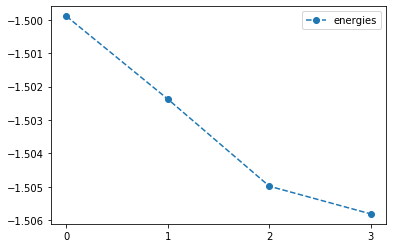

In [24]:
# this will get stuck (similar for other gradient based optimizers)
zeroes = {'a':0.0, 'b':0.0}
shift = 1.0
O = tq.Objective.ExpectationValue(U=U, H=H)
result = tq.optimizer_scipy.minimize(objective=O, method='TNC', initial_values=zeroes)
result.history.plot()

Optimizer: <class 'tequila.optimizers.optimizer_scipy.OptimizerSciPy'> 
backend         : None
backend_options : {}
samples         : None
save_history    : True
noise_model     : None

Method          : TNC
Objective       : 1 expectationvalues
bounds          : {a: (-6.183185307179587, -0.1), b: (-6.183185307179587, -0.1), c: (-6.183185307179587, -0.1)}
gradient        : 12 expectationvalues

active variables : 3

Gradient:

Hessian:

None
E=-0.93282629  angles= {c: -0.1, b: -0.1, a: -0.1}  samples= None
E=-0.93282632  angles= {c: -0.1, b: -0.1000000260708811, a: -0.1}  samples= None
E=-0.93282632  angles= {c: -0.10000000000000009, b: -0.10000002095701488, a: -0.10000000000000009}  samples= None
E=-0.85684291  angles= {c: -0.10000000000000009, b: -1.037600964376601, a: -0.10000000000000009}  samples= None
E=-1.52410957  angles= {c: -0.10000000000000009, b: -0.5688004821883004, a: -0.10000000000000009}  samples= None
E=-1.17486323  angles= {c: -0.10000000000000009, b: -0.3344002410941

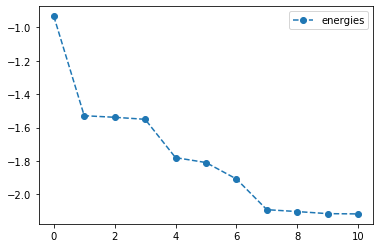

In [25]:
# bounding the variables to keep it away from the stationary point which occurs at 0 and is periodic in 2pi
# using negative values since that converges faster
zeroes = {'a':0.0, 'b':0.0}
shift = 1.0
bounds = {'a':(-2*numpy.pi+0.1, -0.1), 'b':(-2*numpy.pi+0.1, -0.1), 'c':(-2*numpy.pi+0.1, -0.1) }
O = tq.Objective.ExpectationValue(U=U, H=H)
result = tq.optimizer_scipy.minimize(objective=O, method='TNC', initial_values=zeroes, method_bounds=bounds)
result.history.plot()

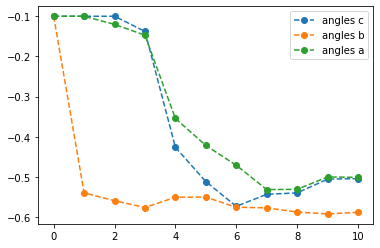

In [26]:
result.history.plot('angles')